In [7]:
import os
os.makedirs('models', exist_ok=True)  # ✅ creates it if missing

with open('models/tfidf_vectorizer.pkl', 'wb') as f:
    pickle.dump(tfidf, f)
recipes.to_pickle('models/recipes_mapping.pkl')

In [3]:
import pandas as pd
import re
import unicodedata
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel
import pickle
from rapidfuzz import fuzz, process

# -------------------------
# 1) Load and basic checks
# -------------------------
df = pd.read_excel("data/recipes.xlsx")           # change path if needed
df = df[['recipe_name', 'food_name_org']].copy()
df = df.dropna(subset=['recipe_name']).reset_index(drop=True)

# Keep original recipe name for display
df['recipe_name_orig'] = df['recipe_name']

# -------------------------
# 2) Normalization helpers
# -------------------------
COMMON_REMOVALS = r'\b(a|an|the|and|or|of|fresh|chopped|sliced|diced|minced|large|small|medium|to taste)\b'

def normalize_text(s: str) -> str:
    """Basic unicode normalize + lower + strip."""
    if not isinstance(s, str):
        s = str(s)
    s = s.strip().lower()
    s = unicodedata.normalize('NFKD', s)
    return s

def normalize_ingredient_token(token: str) -> str:
    """Remove parenthetical content, quantities, punctuation, and common fluff words."""
    t = normalize_text(token)
    t = re.sub(r'\([^)]*\)', ' ', t)   # remove "(...)" content
    # remove common quantity patterns like "1", "1/2", "200g", "2.5 kg", "1 tsp"
    t = re.sub(r'\b\d+([\/\.\-]\d+)?\s*(g|kg|gram|grams|ml|l|tbsp|tbsp\.|tsp|cup|cups|oz|ounce|cl|kg|mg)?\b', ' ', t)
    # remove punctuation but keep hyphens inside words
    t = re.sub(r'[^\w\s-]', ' ', t, flags=re.UNICODE)
    # remove fluff words (chopped, fresh, etc.)
    t = re.sub(COMMON_REMOVALS, ' ', t)
    t = re.sub(r'\s+', ' ', t).strip()
    return t

def split_ingredients(s: str):
    """
    Split ingredient field into sensible sub-ingredients.
    Splits on common separators and ' and '.
    """
    if not isinstance(s, str):
        return []
    s = s.strip()
    if s == '':
        return []
    parts = re.split(r',|/|;|\||\band\b| & ', s)
    tokens = []
    for p in parts:
        p = p.strip()
        if not p:
            continue
        norm = normalize_ingredient_token(p)
        if norm:
            tokens.append(norm)
    return tokens

# -------------------------
# 3) Build ingredient lists per recipe
# -------------------------
# Apply splitting to each raw ingredient cell (don't pre-clean the whole column aggressively)
df['ingredient_tokens'] = df['food_name_org'].fillna('').apply(split_ingredients)

# Now group by recipe_name (normalized)
df['recipe_name_clean'] = df['recipe_name'].apply(normalize_text)
grouped = (
    df.groupby('recipe_name_clean')
      .agg({
          'recipe_name_orig': 'first',      # preserve first original label
          'ingredient_tokens': lambda lists: [tok for sub in lists for tok in sub]  # flatten lists
      })
      .reset_index()
)

# Deduplicate while preserving order
def dedup_preserve_order(lst):
    seen = set()
    out = []
    for x in lst:
        if x not in seen:
            seen.add(x)
            out.append(x)
    return out

grouped['ingredients'] = grouped['ingredient_tokens'].apply(dedup_preserve_order)
# For vectorizer we'll create a string where each ingredient is a token (join with " || ")
# so multi-word ingredients are preserved as single tokens by a custom tokenizer below.
grouped['ingredient_text'] = grouped['ingredients'].apply(lambda L: ' || '.join(L))

# Keep a mapping for display / lookups
recipes = grouped[['recipe_name_clean', 'recipe_name_orig', 'ingredients', 'ingredient_text']].copy()

# -------------------------
# 4) TF-IDF (token-per-ingredient)
# -------------------------
# We'll set tokenizer to split on ' || ' so that each ingredient (possibly multi-word) remains atomic.
def ingredient_tokenizer(s):
    return [t.strip() for t in s.split('||') if t.strip()]

tfidf = TfidfVectorizer(tokenizer=ingredient_tokenizer, lowercase=False,
                        ngram_range=(1, 1),  # single "ingredient tokens"
                        max_features=5000)   # cap features to avoid noise

tfidf_matrix = tfidf.fit_transform(recipes['ingredient_text'])

# Precompute similarity matrix (fast for moderate-size datasets).
# For very large datasets, compute per-query with linear_kernel(tfidf[idx], tfidf) instead.
cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)  # dense-ish but fast

# -------------------------
# 5) Query function (robust)
# -------------------------
def get_similar_recipes(query_recipe_name: str, top_n: int = 5):
    query = normalize_text(query_recipe_name)
    
    # Search for the best match using RapidFuzz's process.extractOne
    match = process.extractOne(query, recipes['recipe_name_clean'], scorer=fuzz.ratio)
    
    if match and match[1] > 80:  # Adjust threshold as needed
        idx = recipes.index[recipes['recipe_name_clean'] == match[0]][0]
    else:
        raise ValueError(f"Recipe '{query_recipe_name}' not found. Try one of: {recipes['recipe_name_orig'].sample(5).tolist()}")
    
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

    results = []
    for i, score in sim_scores:
        if i == idx:
            continue
        results.append({
            'recipe_name': recipes.loc[i, 'recipe_name_orig'],
            'recipe_key': recipes.loc[i, 'recipe_name_clean'],
            'score': float(score),
            'top_ingredients': recipes.loc[i, 'ingredients'][:6]
        })
        if len(results) >= top_n:
            break
    
    return results


# -------------------------
# 6) Example usage
# -------------------------
# Example: find similar recipes
print("Example query -> 'Chicken salad'")
try:
    similar = get_similar_recipes('Chicken salad', top_n=5)
    for r in similar:
        print(f"{r['recipe_name']}  (score={r['score']:.4f})  |  top_ingredients={r['top_ingredients']}")
except ValueError as e:
    print(e)

# -------------------------
# 7) Save artifacts (optional)
# -------------------------
with open('models/tfidf_vectorizer.pkl', 'wb') as f:
    pickle.dump(tfidf, f)
# You can also pickle 'recipes' dataframe (mapping)
recipes.to_pickle('models/recipes_mapping.pkl')


Example query -> 'Chicken salad'
Chicken and tomato towers  (score=0.7199)  |  top_ingredients=['lettuce', 'capsicum', 'green', 'celery stalk', 'tomato', 'ripe']
Chicken walnut sandwich (Chicken aur akhrot ke sandwich)  (score=0.6812)  |  top_ingredients=['pepper', 'black', 'walnut', 'chicken', 'poultry', 'breast']
Roast chicken  (score=0.6461)  |  top_ingredients=['lemon', 'juice', 'pepper', 'black', 'chicken', 'poultry']
Pin wheel sandwich  (score=0.4797)  |  top_ingredients=['pepper', 'black', 'egg', 'poultry', 'whole', 'raw']
Deviled egg  (score=0.4648)  |  top_ingredients=['lettuce', 'tomato', 'ripe', 'hybrid', 'onion', 'big']


c:\Users\ISHAAN\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\feature_extraction\text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [4]:
# Sample queries from your dataset
sample_queries = recipes['recipe_name_orig'].sample(5).tolist()

for q in sample_queries:
    print(f"\nQuery: {q}")
    try:
        results = get_similar_recipes(q, top_n=5)
        for r in results:
            print(f"{r['recipe_name']}  (score={r['score']:.4f})  |  top_ingredients={r['top_ingredients']}")
    except ValueError as e:
        print(e)



Query: Fish curry (Machli curry)
Chicken curry  (score=0.6765)  |  top_ingredients=['tomato', 'ripe', 'hybrid', 'coriander leaves', 'garlic', 'clove']
Pea keema curry (Matar keema ki sabzi)  (score=0.6535)  |  top_ingredients=['peas', 'tomato', 'ripe', 'hybrid', 'coriander leaves', 'garlic']
Mutton biryani/biriyani  (score=0.6114)  |  top_ingredients=['rice', 'parboiled', 'milled', 'tomato', 'ripe', 'hybrid']
Tandoori fish  (score=0.6022)  |  top_ingredients=['tomato', 'ripe', 'hybrid', 'garlic', 'clove', 'ginger']
Tomato sauce  (score=0.5825)  |  top_ingredients=['tomato', 'ripe', 'hybrid', 'garlic', 'clove', 'ginger']

Query: Pav bhaji masala
Pav bhaji  (score=0.6817)  |  top_ingredients=['capsicum', 'green', 'cauliflower', 'french beans', 'hybrid', 'peas']
Garam masala  (score=0.5335)  |  top_ingredients=['cardamom', 'black', 'cloves', 'coriander seeds', 'cumin seeds', 'pepper']
Shahi keema kofta curry  (score=0.4890)  |  top_ingredients=['tomato', 'ripe', 'hybrid', 'coriander leav

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

def visualize_similar_recipes(query_recipe_name: str, top_n: int = 5):
    """
    Show top similar recipes in a table and a heatmap of ingredient similarity.
    """
    # Get top similar recipes
    results = get_similar_recipes(query_recipe_name, top_n=top_n)
    
    if not results:
        print(f"No similar recipes found for '{query_recipe_name}'")
        return
    
    # Create a DataFrame
    df_results = pd.DataFrame(results)
    
    # Table display
    print("\nTop similar recipes:")
    display(df_results[['recipe_name', 'score', 'top_ingredients']])
    
    # Heatmap of cosine similarity scores
    scores = [r['score'] for r in results]
    names = [r['recipe_name'] for r in results]
    
    plt.figure(figsize=(8, 2))
    sns.heatmap([scores], annot=True, fmt=".2f", xticklabels=names, yticklabels=[query_recipe_name], cmap="YlGnBu")
    plt.title(f"Cosine Similarity with '{query_recipe_name}'")
    plt.show()



Top similar recipes:


,recipe_name,score,top_ingredients
0,Chicken and tomato towers,0.719915,"[lettuce, capsicum, green, celery stalk, tomat..."
1,Chicken walnut sandwich (Chicken aur akhrot ke...,0.681238,"[pepper, black, walnut, chicken, poultry, breast]"
2,Roast chicken,0.646059,"[lemon, juice, pepper, black, chicken, poultry]"
3,Pin wheel sandwich,0.479718,"[pepper, black, egg, poultry, whole, raw]"
4,Deviled egg,0.464827,"[lettuce, tomato, ripe, hybrid, onion, big]"


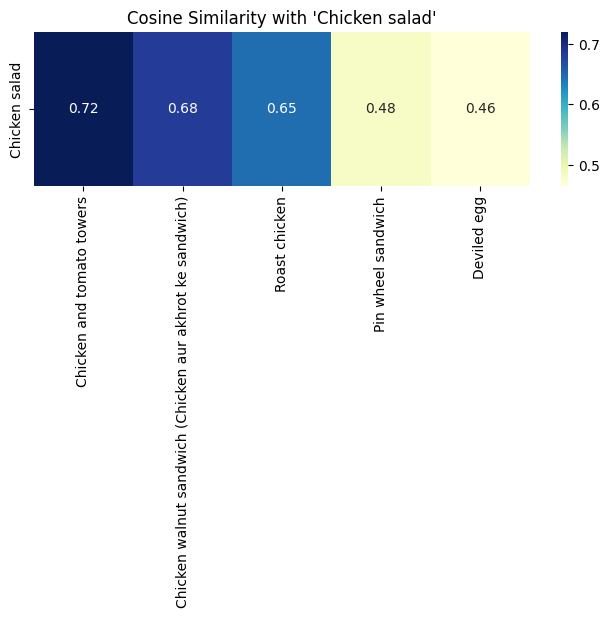

In [6]:
visualize_similar_recipes("Chicken salad", top_n=5)
